Most Sentiment Analysis datasets involve ''positive'' or ''negative'' polarities.

This dataset contains six-basic emotions:**anger**,**disgust**,**fear**,**joy**,**sadness**,and **surprise** based on what their content of the tweets.

Given a tweet our task will be to train a model that can classify it into one of these emotions.

**Load the Dataset**

1.Before download a dataset, it’s often helpful to quickly get some general information about a dataset. Use the load_dataset_builder()

2.Use the load_dataset_builder() function to load a dataset builder and inspect a dataset’s attributes without committing to downloading it

3.If you’re happy with the dataset, then load it with load_dataset()




In [10]:
!pip install datasets
import datasets
from datasets import load_dataset


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.4 MB/s eta 0:00:00


In [11]:
emotions = load_dataset("emotion")
import pandas as pd
emotions

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds=emotions["train"]
print(train_ds[0])
print(train_ds[0]['text'])
print(train_ds[0]['label'])

{'text': 'i didnt feel humiliated', 'label': 0}
i didnt feel humiliated
0


We can see what data types are being used under the
 hood by accessing the features attribute of a Dataset object:

In [ ]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

while the label column is a
 special ClassLabel object that contains information about the class names and their
 mapping to integers

 it is often convenient to convert a Dataset object to a Pandas DataFrame so we
 can access high-level APIs for data visualization. To enable the conversion,  Datasets provides a set_format() method that allows us to change the output format of
 the Dataset.


In [ ]:
import pandas as pd
emotions.set_format(type="pandas")
print(emotions)
df=emotions['train'][:]
df.head()



DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Whenever you are working on text classification problems, it is a good idea to exam
ine the distribution of examples across the classes.

A dataset with a skewed class dis
tribution might require a different treatment in terms of the training loss and
 evaluation metrics than a balanced one.

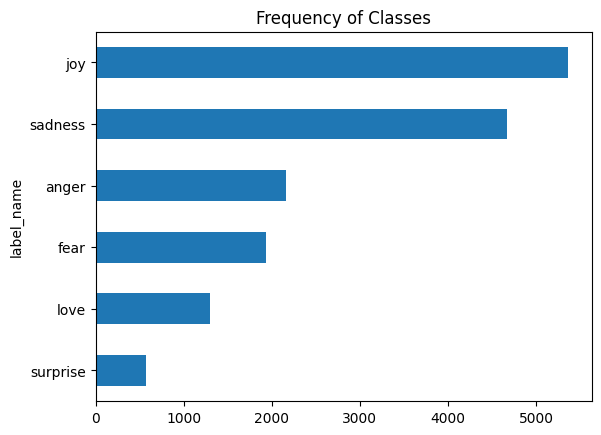

In [ ]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

 In this case, we can see that the dataset is heavily imbalanced; the joy and sadness
 classes appear frequently, whereas love and
 surprise are about 5–10 times rarer.
 There are several ways to deal with imbalanced data, including:

*   Randomly oversample the minority class.
*   Randomly undersample the majority class.
*   Gather more labeled data from the underrepresented classes.






  




**How Long are our tweets**

Transformer models have a maximum input sequence length that is referred to as the
 maximum context size. For applications using DistilBERT, the maximum context size
 is 512 tokens, which amounts to a few paragraphs of text

We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet:




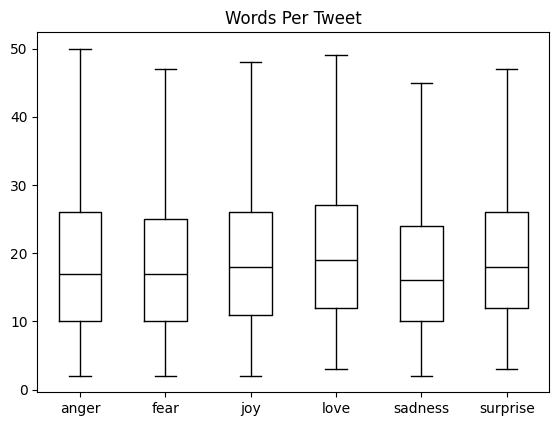

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

. Understanding the Components of the Box Plot
Each box represents a summary of a dataset's distribution, and it consists of:

Median (Middle Line in the Box): This is the 50th percentile, meaning half of the tweets have fewer words, and half have more.

Interquartile Range (IQR) (Box Itself): The box extends from the 25th percentile (Q1) to the 75th percentile (Q3). This represents the middle 50% of the data.

Whiskers (Vertical Lines Extending from the Box): These show the minimum and maximum word counts, excluding outliers.

Outliers (Dots Beyond the Whiskers, If Any): Extreme values that don’t fit within the general trend.


In [ ]:
emotions.reset_format()

Tokenization


In [1]:
from transformers import AutoTokenizer
model_ckpt="distilbert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
text="Tokenization task is a core task of NLP"
encoded_text=tokenizer(text)
print(encoded_text)
tokens=tokenizer.convert_ids_to_tokens(encoded_text.input_ids) #the input_ids,can convert back into tokens by using the tokenizer’s convert_ids_to_tokens() method:
print(tokens)
print(tokenizer.convert_tokens_to_string(tokens))
print(tokenizer.vocab_size)
print(tokenizer.model_max_length) #corresponding model’s maximum context size
tokenizer.model_input_names

{'input_ids': [101, 19204, 3989, 4708, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'token', '##ization', 'task', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']
[CLS] tokenization task is a core task of nlp [SEP]
30522
512


['input_ids', 'attention_mask']

### Tokenizing the whole dataset
To tokenize the whole corpus, we’ll use the map() method of our DatasetDict object


In [13]:
def tokenize(batch):
  return tokenizer(batch["text"],padding=True,truncation=True)
print(tokenize(emotions["train"][:2])) #For each batch, the input sequences are padded to the maximum sequence length in the batch;
                                       #the attention mask is used in the model to ignore the padded areas of the input tensors
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Transformer as feature extractor
freeze the body’s weights during training and use the hidden states as
features for the classifier.

advantage of this approach is that we can quickly train a small or shallow model

In [18]:
import torch
from transformers import AutoModel
model_ckpt="distilbert-base-uncased"
device=torch.device("cuda" if torch.cuda.is_available() else "cpu") #PyTorch to check whether a GPU is available or not,
model=AutoModel.from_pretrained(model_ckpt).to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [19]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt") #The first thing we need to do is encode the string and convert the tokens to PyTorch tensors
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [21]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():  #the torch.no_grad() context manager to disable the automatic calculation of the gradient
  outputs = model(**inputs)
print(outputs)

outputs.last_hidden_state.size()

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


torch.Size([1, 6, 768])

In [22]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [25]:
def extract_hidden_states(batch):
 # Place model inputs on the GPU
 inputs = {k:v.to(device) for k,v in batch.items()
                        if k in tokenizer.model_input_names}
 # Extract last hidden states
 with torch.no_grad():
  last_hidden_state = model(**inputs).last_hidden_state

 # Return vector for [CLS] token
 return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}





In [26]:
emotions_encoded.set_format("torch",
 columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

## Creating a feature matrix

In [28]:
 import numpy as np
 X_train = np.array(emotions_hidden["train"]["hidden_state"])
 X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
 y_train = np.array(emotions_hidden["train"]["label"])
 y_valid = np.array(emotions_hidden["validation"]["label"])
 X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Visualize the training set

In [29]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.192872,6.523153,0
1,-3.256139,5.712648,0
2,5.508312,3.186636,3
3,-2.298429,3.534367,2
4,-3.462550,3.421256,3


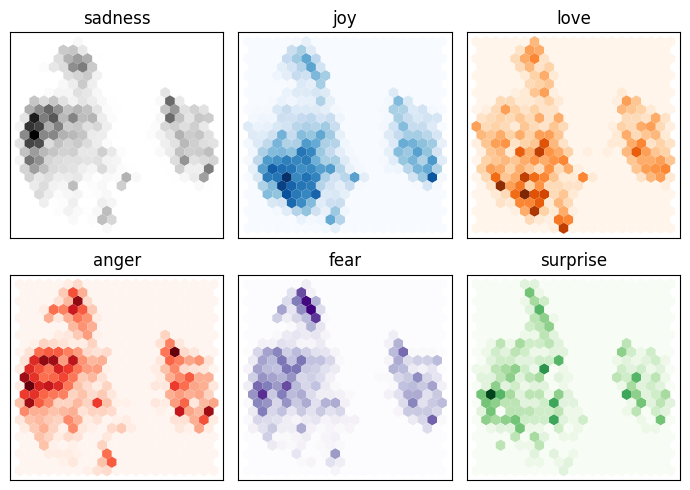

In [32]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
             gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

From this plot we can see some clear patterns:
the negative feelings such as sadness,anger, and fear all occupy similar regions with slightly varying distributions.
On the other hand, joy and love are well separated from the negative emotions and also share a similar space.

Training a simple classifier using the feature extracted by the  pretrained DistilBER model


In [33]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.635